# Basic usage **pdfmole**

In [1]:
from pdfmole import read_pdf, group_blocks, align_exact_match, kdplot
import numpy as np
import pandas as pd

## Read the pdf-file

In [2]:
doc = read_pdf("../samples/cars.pdf")

Each pdf consists of several elements:

In [3]:
doc.elements

['metainfo',
 'text',
 'line',
 'rect',
 'curve',
 'figure',
 'textline',
 'textbox',
 'textgroup',
 'image']

There is a get function for each element type `get_<element>`

In [4]:
doc.get_metainfo()

,pid,rotate,x0,y0,x1,y1
0,1,0,0,0,595,842
1,2,0,0,0,595,842


By default the get methods return pandas `DataFrame` but the return type can also be changed to `list[dict]`.

In [5]:
doc.get_metainfo("list")

[{'pid': 1, 'rotate': 0, 'x0': 0, 'y0': 0, 'x1': 595, 'y1': 842},
 {'pid': 2, 'rotate': 0, 'x0': 0, 'y0': 0, 'x1': 595, 'y1': 842}]

## Transform the data into a rectangular format

In [6]:
d = doc.get_text()
d.head(3)

,pid,block,text,font,size,colorspace,color,x0,y0,x1,y1
0,1,1.0,s,Courier-Bold,12.0,DeviceGray,"[0, 0, 0]",77.2,751.272,84.4,763.272
1,1,1.0,p,Courier-Bold,12.0,DeviceGray,"[0, 0, 0]",84.4,751.272,91.6,763.272
2,1,1.0,e,Courier-Bold,12.0,DeviceGray,"[0, 0, 0]",91.6,751.272,98.8,763.272


The method `get_text` returns the columns

- `pid` ... an integer giving the page id.
- `block` ... an integer giving the id of some grouping information provided by pdfminer.
- `text` ... a character to be refined to the text.
- `font` ... a string giving the font name.
- `size` ... a float giving the font size.
- `colorspace` ... a string giving the color space.
- `color` ... a tuple of int giving the color.
- `x0` ... a float giving the distance from the left of the page to the left edge of the bounding box.
- `y0` ... a float giving the distance from the bottom of the page to the lower edge of the bounding box.
- `x1` ... a float giving the distance from the left of the page to the right edge of the bounding box.
- `y1` ... a float giving the distance from the bottom of the page to the upper edge of the bounding box.

for each character in the document.

### 1. Remove control characters

In [7]:
deleted = d[~(d['size'] > 0)]
d = d[d['size'] > 0]
deleted.head(3)

,pid,block,text,font,size,colorspace,color,x0,y0,x1,y1
5,1,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,1,NaN,\n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,1,NaN,\n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2. Group the blocks
In many situations the grouping information provided by pdfminer is helpfull. So we start by grouping the blocks.

In [8]:
d = group_blocks(d)
d.head(3)

,pid,text,font,size,colorspace,color,rotated,x0,y0,x1,y1
0,1,speed,Courier-Bold,12.0,DeviceGray,"[0, 0, 0]",-1,77.2,751.272,113.2,763.272
1,1,dist,Courier-Bold,12.0,DeviceGray,"[0, 0, 0]",-1,124.4,751.272,153.2,763.272
2,1,4,Courier,12.0,DeviceGray,"[0, 0, 0]",-1,115.2,736.272,122.4,748.272


Group blocks adds a rotated column, the usage of this column is shown in the [`Rotated_Text`]() vignette. Here we won't use it therfore we remove it along with other unused columns.

In [9]:
rm_us = {"rotated", "size", "colorspace", "color"}
d = d[[k for k in d.columns if not k in rm_us]]

### 3. Filter
Information like the font name and font size can be used to remove headers and footers.

In [10]:
d.tail(3)

,pid,text,font,x0,y0,x1,y1
153,2,120,Courier,140.4,691.272,162.00,703.272
154,2,85,Courier,147.6,676.272,162.00,688.272
155,2,Page 2,BAAAAA+LiberationSans,281.8,58.290,313.46,68.290


In [11]:
d = d[d['font'].str.startswith("Courier")]

### 4. Infer the row ids
The **R** [**pdfmole**](https://github.com/FlorianSchwendinger/pdfmole) package has also an alignment method based on hierarchical clustering. This package currently only contains an exact match alignment method.

We round the `'y0'` coordinates to cover at least some fuzzyness.

In [12]:
d = d.assign(rowid = align_exact_match(d['y0'].round()))

### 5. Infer the column ids
An easy approach to choose the column ids to provide the column width as in fixed width csv files.

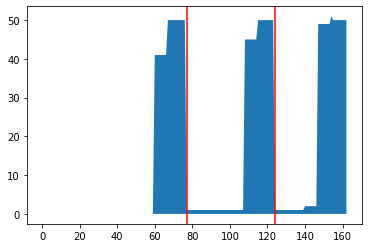

In [13]:
plt, grid = kdplot(d)
column_splits = np.array(range(len(grid) - 1))[(grid[:-1] - grid[1:]) > 30] + 1
plt.axvline(column_splits[0], color = "red")
plt.axvline(column_splits[1], color = "red")
plt.show()

In [14]:
d['colid'] = -1
for col_id, column_split in enumerate(column_splits):
    b = (d['colid'] < 0) & ((d['x0'] + d['x1']) / 2 < column_split)
    d.loc[b, 'colid'] = col_id

d.loc[d['colid']<0, 'colid'] = col_id + 1

### 6. Transform data into tabular form
To transform the data into a tabular form, we will first transform the `DataFrame` into a [coordinate list sparse matrix](https://en.wikipedia.org/wiki/Sparse_matrix#Coordinate_list_(COO)) format (also known as simple triplet matrix format.)

In [15]:
group_keys = ['pid', 'rowid', 'colid']
d = d.sort_values(by = group_keys + ['x0'])
coo_df = d.groupby(group_keys)['text'].apply(' '.join).reset_index()
coo_df['row_id'] = (~coo_df[['pid', 'rowid']].duplicated()).cumsum() - 1
coo_df = coo_df[['row_id', 'colid', 'text']]
coo_df = coo_df.rename(columns={'colid': 'col_id'})
coo_df.head()


,row_id,col_id,text
0,0,1,speed
1,0,2,dist
2,1,0,1
3,1,1,4
4,1,2,2


Second, we transform it to a matrix and then to a `DataFrame`.

In [16]:
ncol = coo_df['col_id'].max() + 1
nrow = coo_df['row_id'].max() + 1
mat = np.array((nrow * ncol) * ['NA'], dtype='object').reshape((nrow, ncol))
for _, row  in coo_df.iterrows():
    i, j, v = row
    mat[i, j] = v

di = {mat[0,1]: mat[1:,1].astype(int), mat[0,2]: mat[1:,2].astype(int)}
df = pd.DataFrame(di)
df.head()

,speed,dist
0,4,2
1,4,10
2,7,4
3,7,22
4,8,16
